In [1]:
using divand
using PyPlot
using Dates

## Files and directories

In [2]:
datadir = "/home/ctroupin/Projects/Altimetry-Interpolation/data/AVISO/"
bathname = "gebco_30sec_16.nc"
filelist = [joinpath(datadir, f) for f in readdir(datadir)];
info("Number of files: $(length(filelist))")

INFO: Number of files: 363


## Analysis parameters
### Grid

In [3]:
dx = 0.5;
dy = 0.5;
lonr = -6.75:dx:40.; 
latr = 30.:dy:48.;
daystart = DateTime(2014,1,1,0,0);
dayendd = DateTime(2014,1,3,0,0);

## Bathymetry and mask

In [4]:
if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,[0]);

INFO: Bathymetry file already downloaded
INFO: Extracting bathymetry from file: gebco_30sec_16.nc
INFO: Creating land-sea mask on level: 0
INFO: Extracting bathymetry from file: gebco_30sec_16.nc


### Time vector

In [12]:
dater = collect(daystart:Dates.Day(1):dayendd);
# Convert to seconds
timer = map(x -> datetime2unix(x), dater);
@show dater;
@show timer;

dater = DateTime[2014-01-01T00:00:00, 2014-01-02T00:00:00, 2014-01-03T00:00:00]
timer = [1.38853e9, 1.38862e9, 1.38871e9]


### Metrics

In [13]:
mask0, (px, py, pt), (xi, yi, ti) = divand_rectdom(lonr, latr, timer);

In [14]:
@show size(mask0);

size(mask0) = (94, 37, 3)


## Data

In [15]:
obsval,obslon,obslat,obsdepth,obstime = loadaviso(filelist);

LoadError: [91mUndefVarError: loadaviso not defined[39m

### Convert the dates in seconds since the unix epoch 1970-01-01

In [93]:
obstimesec = map(x -> datetime2unix(x), obstime);

### Observation and bathymetry

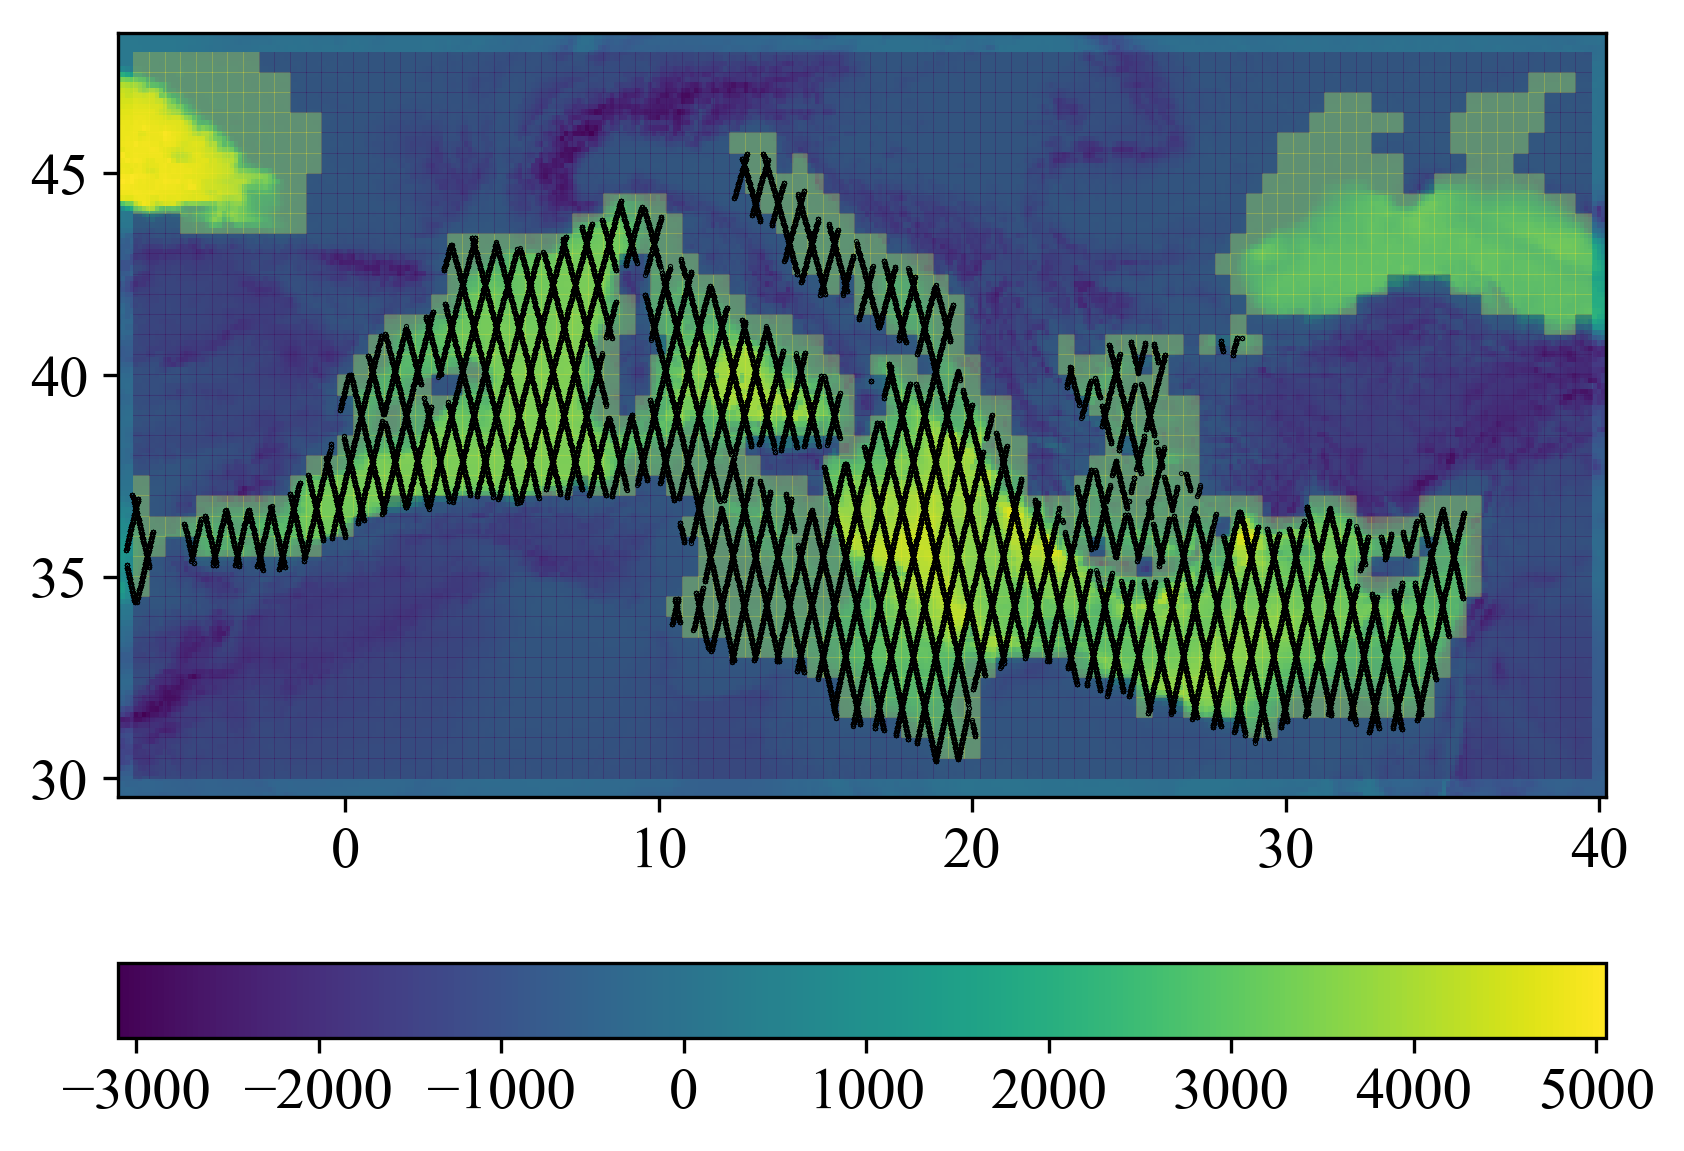

In [94]:
pcolor(bx,by,b'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
plot(obslon, obslat, "ko", markersize=.25)
pcolor(xmask,ymask,Float64.(mmask[:,:,1])', alpha=.25); 
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca()[:set_aspect](aspect_ratio)

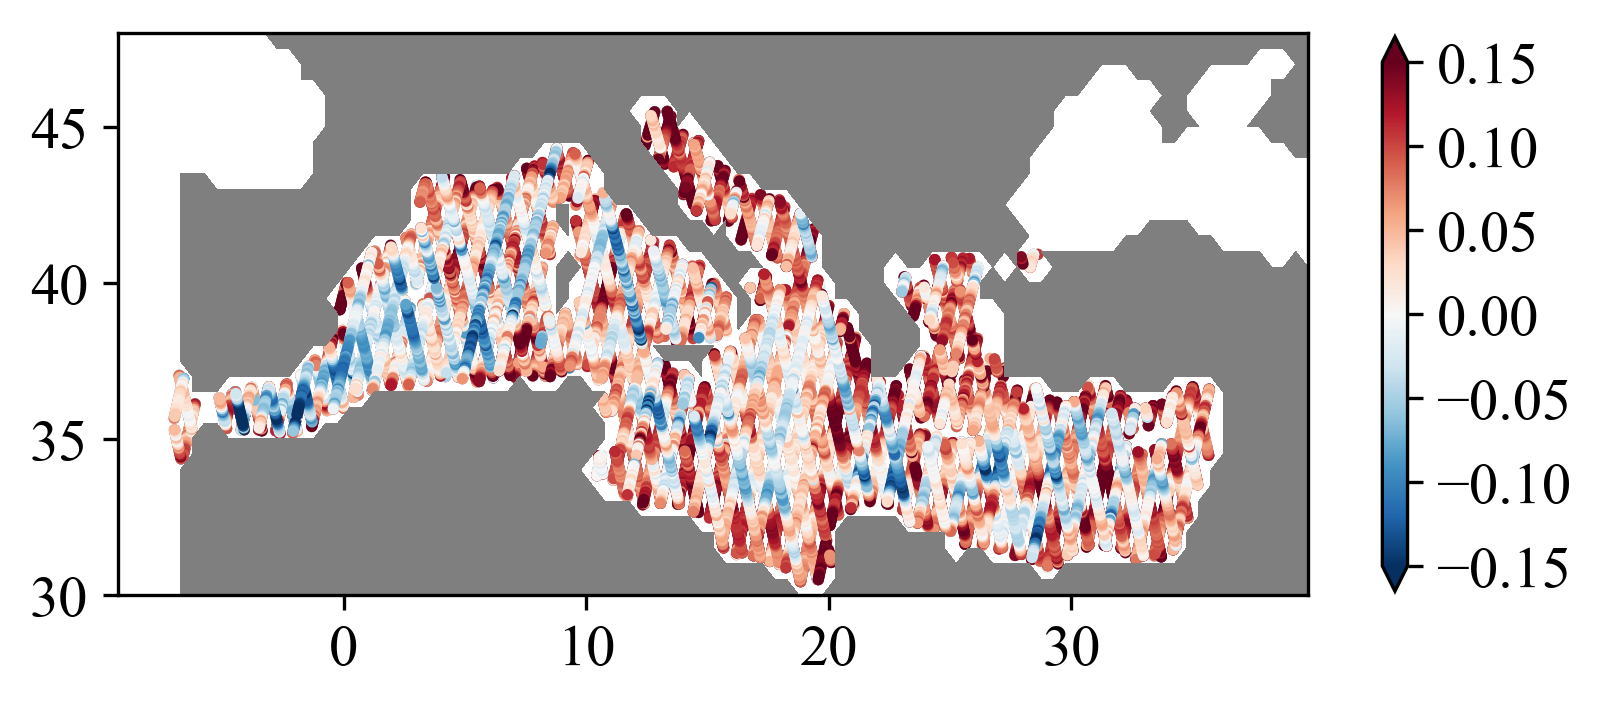

In [95]:
scatter(obslon, obslat, c=obsval-mean(obsval), s=3, 
    cmap=ColorMap("RdBu_r"), vmin=-.15, vmax=.15)
colorbar(extend="both", shrink=.5)
contourf(xmask, ymask, Float64.(mmask[:,:,1])', levels=[-1e5,0],cmap="binary");
gca()[:set_aspect](aspect_ratio)

## Analysis parameters

In [96]:
sz = (length(lonr),length(latr),length(timer));
lenx = fill(1.,sz); # 100 km
leny = fill(1.,sz); # 100 km
lent = fill(1. * 86400.,sz); # 5 days
len = (lenx, leny, lent);

In [97]:
epsilon2 = 1;

In [98]:
rdiag=1.0./divand.weight_RtimesOne((obslon.data,obslat.data),(0.03,0.03));

In [99]:
epsilon2 = epsilon2 * rdiag;

In [100]:
@time fi,s = divandrun(mask0, (px, py, pt), 
    (xi, yi, ti), (obslon.data, obslat.data, obstimesec.data), 
    obsval.data-mean(obsval.data), len, epsilon2);

INFO: Creating observation error covariance matrix
INFO: Adding observation constraint to cost function
INFO: Factorizing a posteriori error covariance matrix
INFO: Solving...


  0.696474 seconds (4.92 M allocations: 498.203 MiB, 25.58% gc time)


INFO: Done solving


## Plot results and data 

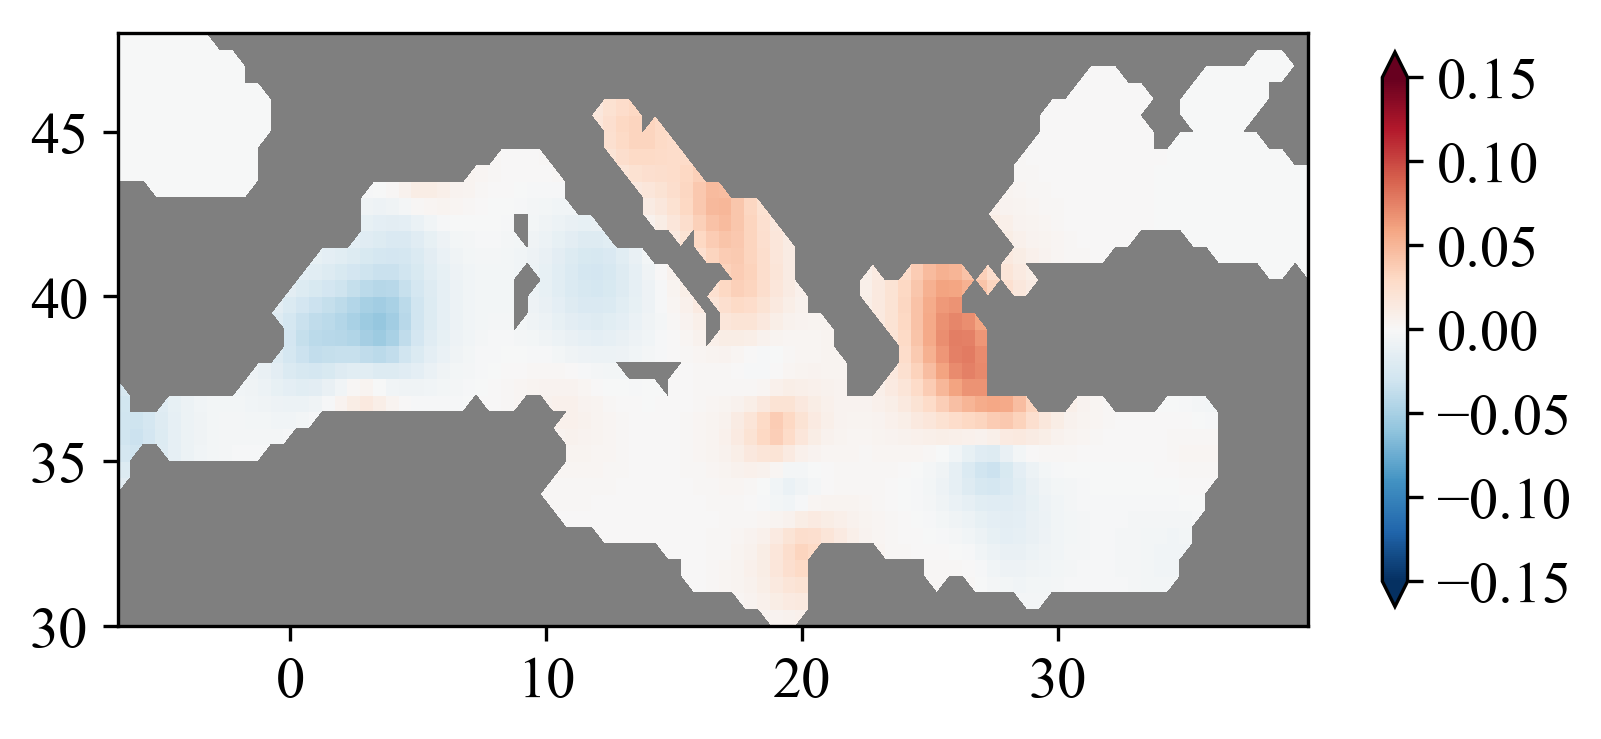

In [102]:
vmax = 0.15;
pcolormesh(lonr, latr, fi[:,:,1]', vmin=-vmax, vmax=vmax, cmap=ColorMap("RdBu_r"))
#scatter(obslon, obslat, c=obsval-mean(obsval), s=3, 
#    cmap=ColorMap("RdBu_r"), vmin=-vmax, vmax=vmax)
colorbar(extend="both", shrink=.5)
contourf(xmask, ymask, Float64.(mmask[:,:,1])', levels=[-1e5,0], cmap="binary");
gca()[:set_aspect](aspect_ratio)